# Find points that belongs to pentagons

In this script, we want to group the data by pentagons. This way we can compute the chirality of each pentagon by looking at the spin values. In this script we will solve the problem for the Shakti lattice.

In [1]:
import os
import sys
import numpy as np
import scipy
from importlib import reload  
sys.path.insert(0, '../icenumerics')

import icenumerics as ice
import shakti as sha
reload(sha)

import matplotlib.pyplot as plt
ureg = ice.ureg
from string import Template

import pandas as pd

%load_ext autoreload
%autoreload 2

First, we build our lattice

In [2]:
# <Define the geometric parameters of the lattice and build the spin lattice>

trap_sep = 10 # Short trap
radius = 5
distance = 3
interparticle_distance = 2*radius + distance # distance among a particle next to the other 
part_d = interparticle_distance*np.cos(np.pi/4) # distance among a particle in front of the other 
plaquette_cte = part_d*4+2*trap_sep
plaquette_cte/2

sp = sha.spins()
ureg = ice.ureg

sp.create_lattice(geometry = "shakti",size =[10,10],lattice_constant=plaquette_cte*ureg.um , border="periodic")

/home/carolina/CairoLattice_ACI_PROJECT/Scripts/shakti.py:251: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new_centers[:,1] = centersY


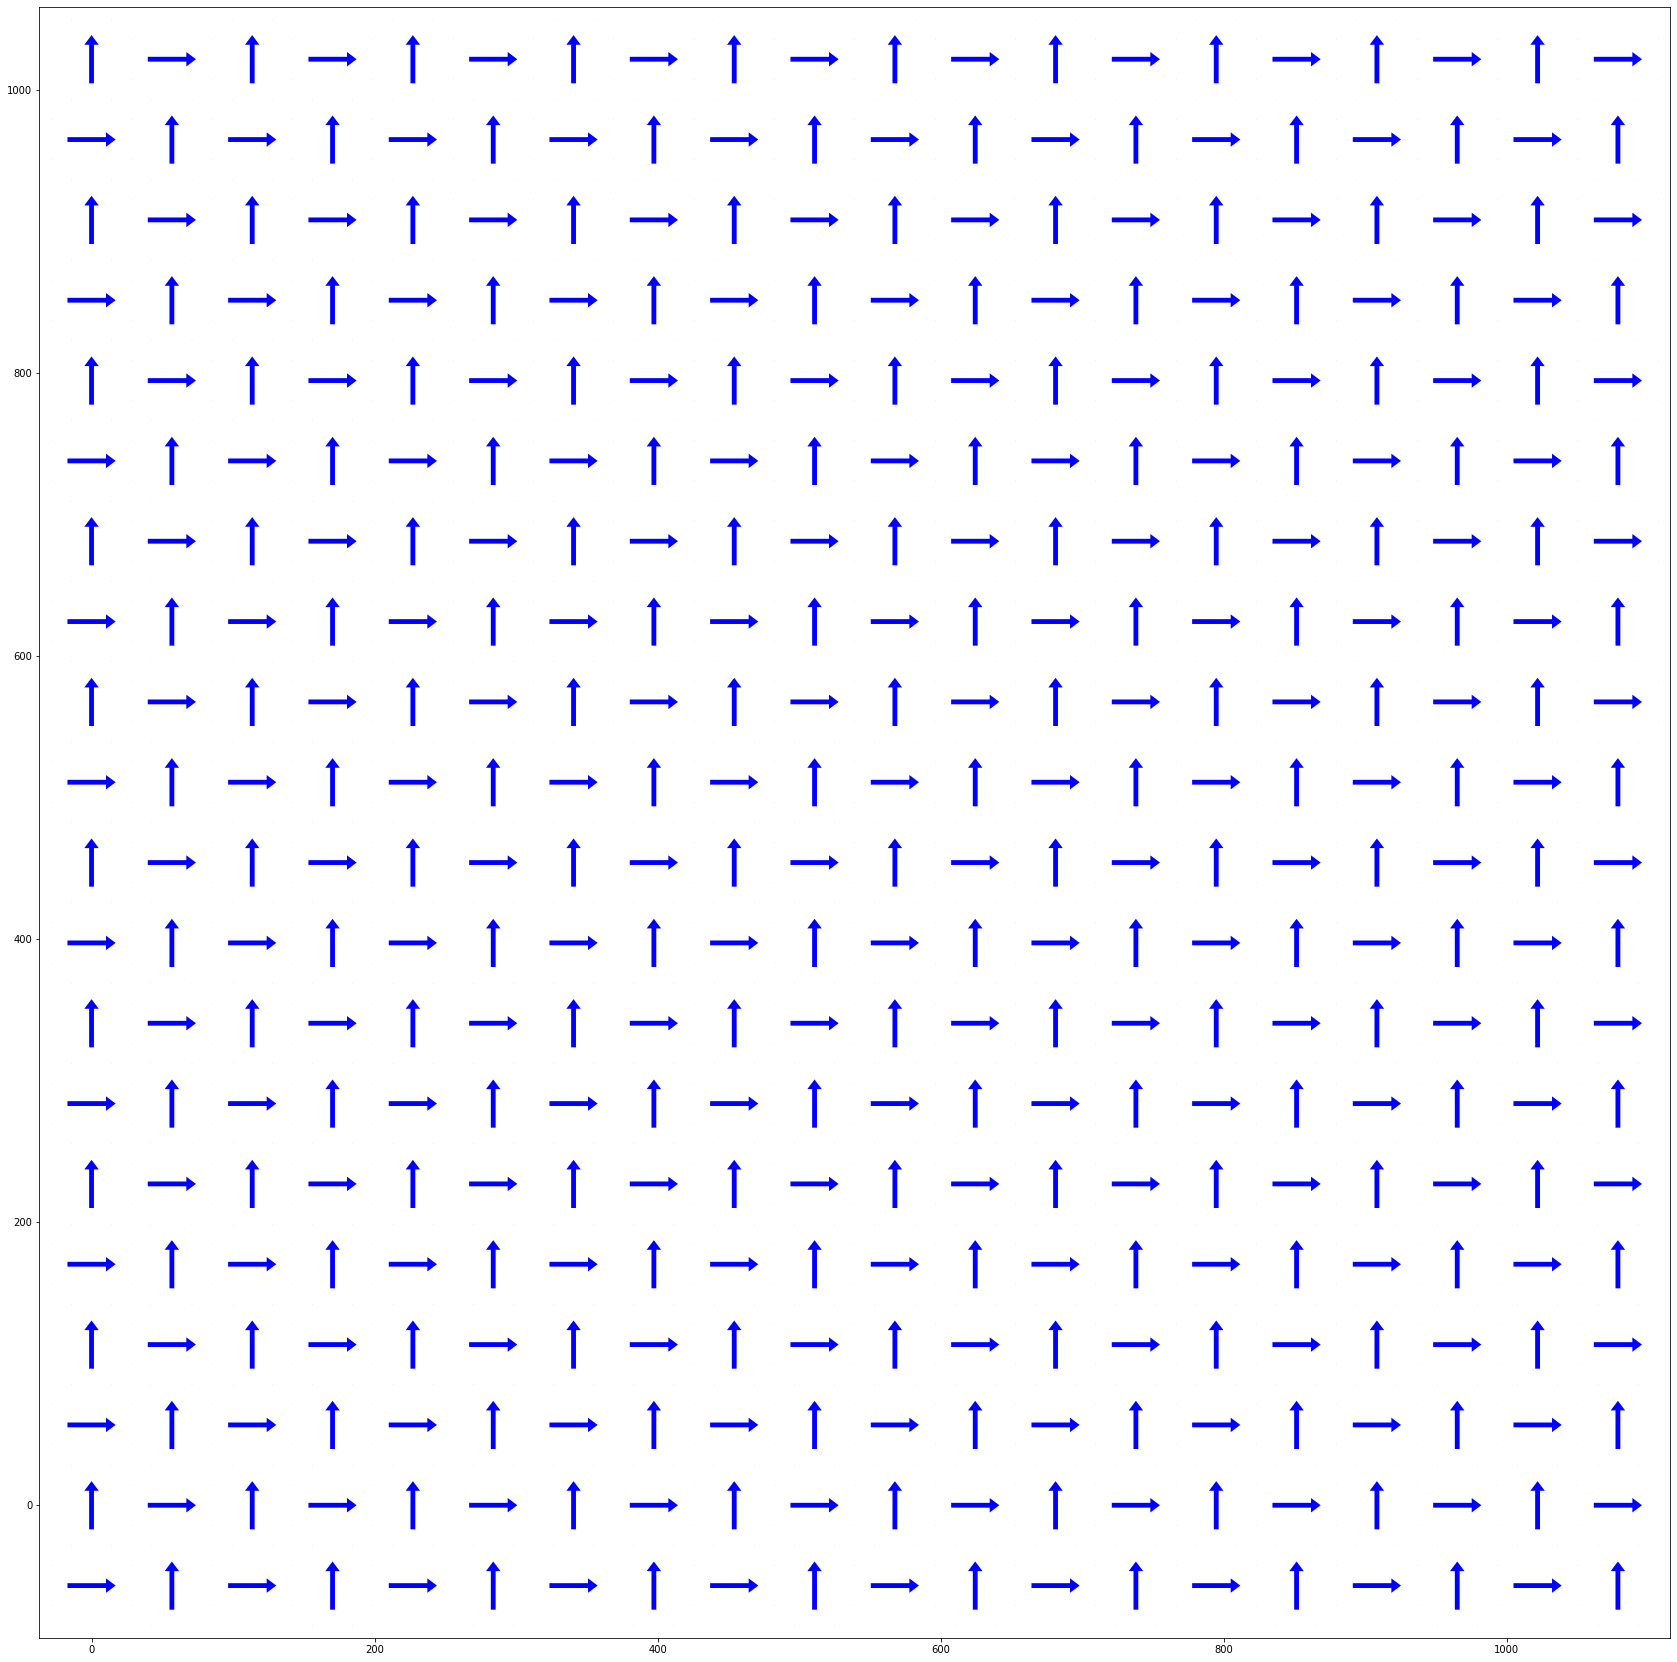

In [3]:
fig, ax1 = plt.subplots(figsize=(30,30))
sp.display(ax1)

And find the centers of the pentagons. First, I need to modify the functions that define the central position of the pentagons. Since, geometrical restrictions now are different some strategies need to be changed.

In [4]:
def separate_central_traps(sp):
    
    central_traps_positions = []
    central_traps_directions = []
    cent_all = []

    
    for s in sp:
        
        cent_all.append(s.center.magnitude)

        if ( s.direction[0].magnitude >= plaquette_cte or s.direction[0].magnitude <= -plaquette_cte or 
            s.direction[1].magnitude >= plaquette_cte or s.direction[1].magnitude <= -plaquette_cte):

            central_traps_positions.append(s.center)
            central_traps_directions.append(s.direction)

        else:
            pass
    
    return central_traps_positions, central_traps_directions, cent_all

In [5]:
def filtrate_horiz_and_vert_spins(central_traps_positions, central_traps_directions):
    
    """ Whit this function we filtrate the center values of vertical and horizontal traps. 
    The input parameter is the sp lattice """
    
    cent_vertical = []
    cent_horizontal = []
    
    i = 0
    for c in central_traps_directions:
        
        if (c.magnitude[0] == 0.):

            cent_vertical.append(central_traps_positions[i])

        elif (c.magnitude[1] == 0.):

            cent_horizontal.append(central_traps_positions[i])
        
        i = i+1    
        
    return cent_vertical, cent_horizontal

In [6]:
central_traps_positions, central_traps_directions, cent_all = separate_central_traps(sp)

In [7]:
vertical, horizontal = filtrate_horiz_and_vert_spins(central_traps_positions, central_traps_directions)

In [8]:
def pentagon_centers(vertical, horizontal):
    
    """ Whit this function we will define the central points of the pentagons, as input parameters
    it takes the output of the function filtrate_horiz_and_vert() and the output are the centers of the poligon."""
    
    pentagon_centers = []
    
    l = 19.5458*ureg.um*1.37 # Geometrical parameters
    
    for i in vertical:
        
        pentagon_centers.append([i[0].magnitude+(l.magnitude/2*(np.cos(60*np.pi/180)+np.cos(30*np.pi/180))),i[1].magnitude, 0])
        pentagon_centers.append([i[0].magnitude-(l.magnitude/2*(np.cos(60*np.pi/180)+np.cos(30*np.pi/180))),i[1].magnitude, 0])
        
    for i in horizontal:
        
        pentagon_centers.append([i[0].magnitude,i[1].magnitude+(l.magnitude/2*(np.cos(60*np.pi/180)+np.cos(30*np.pi/180))), 0])
        pentagon_centers.append([i[0].magnitude,i[1].magnitude-(l.magnitude/2*(np.cos(60*np.pi/180)+np.cos(30*np.pi/180))), 0])
        
     
    pentagon_cent = np.array(pentagon_centers)
    
    return pentagon_cent
        

In [9]:
center_pentagon_points = pentagon_centers(vertical, horizontal)

In [10]:
lattice_points = np.stack( cent_all, axis=0 )

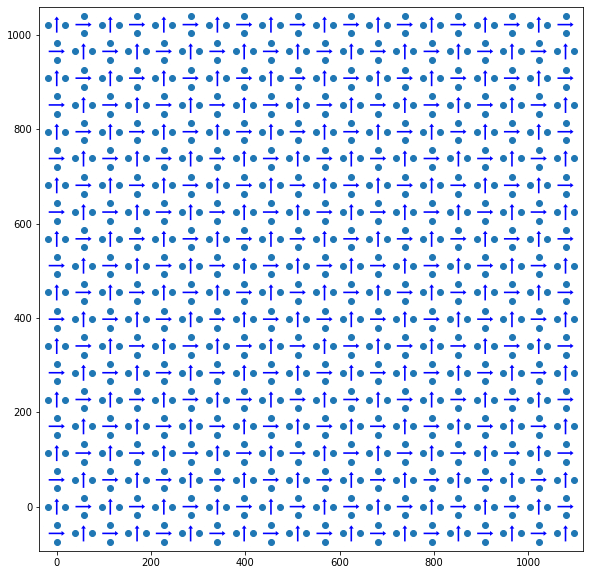

In [11]:
fig, ax1 = plt.subplots(figsize=(20,10))
sp.display(ax1)
plt.plot(center_pentagon_points[:,0],center_pentagon_points[:,1],'o')

To find the 5 nearest neighbours of each center we will build a kdtree and find the nn

In [12]:
KDTree = scipy.spatial.KDTree(lattice_points)

In [13]:
dist, nn_index = KDTree.query(center_pentagon_points, k=5)

In [14]:
nn_index

array([[   6,    7,    0,    2,    4],
       [   0,    1,    3,    2,    4],
       [  32,   31,   15,   19,   17],
       ...,
       [1996, 1997, 1985, 1989, 1987],
       [1983, 1984, 1990, 1993, 1991],
       [1781, 1782, 1990, 1994, 1992]])

In [15]:
nn = []
for i in nn_index[3]:
    nn.append(KDTree.data[i])


In [16]:
nn = np.stack( nn, axis=0 )

(26.965537495307725,
 58.18879143724299,
 -87.99280656363574,
 -25.546298679765215)

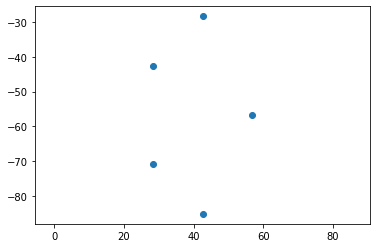

In [17]:
plt.plot(nn[:,0],nn[:,1],'o')
plt.axis('equal')

    It works!!

To get into the position of each label of each side of the pentagon we can write as following:
For the dataset [ 0,  1,  3,  6,  7], the traps involved have the labels 0, 1, 3, 6 and 7. To have the positions we simply do KDTree.data[label]

In [18]:
KDTree.data[1]

array([-14.19238816,  28.38477631,   0.        ])

It would be nice to have a collection of traps positions grouped by the index of the pentagon that belong to. After that, we will need to compare this dataframe with the experimental one, and match the indices. Let's do that:

In [19]:
def save_pentagons_and_coord(nn_index, center_pentagon_points):
    
    """ This function takes the indices of the spins forming each pentagon and have as an output a dataframe
    with the index of the pentagon (form 0 to N) and the coordinates of each spin that belongs to the pentagon.
    
    In this dataframe we also have coordinate of the center of the pentagons (x_c, y_c, z_c) """

    index = []
    x = []
    y = []
    z = []
    x_c = []
    y_c = []
    z_c = []

    i = 0

    for pentagon in nn_index:


        for spin_index in pentagon:

            index.append(i)
            x.append(KDTree.data[spin_index][0])
            y.append(KDTree.data[spin_index][1])
            z.append(KDTree.data[spin_index][2])
            x_c.append(center_pentagon_points[i,0])
            y_c.append(center_pentagon_points[i,1])
            #x_c.append(0)
            #y_c.append(0)
            z_c.append(1)

        i = i+1


    d = {'x': x, 'y': y, 'z': z,'x_c': x_c, 'y_c': y_c, 'z_c': z_c}

    df = pd.DataFrame(data=d, index = index)
    df.index.name = 'pentagon index'

    return df

In [20]:
df = save_pentagons_and_coord(nn_index, center_pentagon_points)

In [21]:
df.head(15)

,x,y,z,x_c,y_c,z_c
pentagon index,,,,,,
0,28.384776,14.192388,0.0,18.289541,0.000000,1
0,28.384776,-14.192388,0.0,18.289541,0.000000,1
0,0.000000,0.000000,0.0,18.289541,0.000000,1
0,14.192388,28.384776,0.0,18.289541,0.000000,1
0,14.192388,-28.384776,0.0,18.289541,0.000000,1
1,0.000000,0.000000,0.0,-18.289541,0.000000,1
1,-14.192388,28.384776,0.0,-18.289541,0.000000,1
1,-14.192388,-28.384776,0.0,-18.289541,0.000000,1
1,14.192388,28.384776,0.0,-18.289541,0.000000,1


We save the data to compare it with the experimental one. 

In [22]:
df.to_csv('Pentagon_coordinates_Script-9.2_theta=0.0.dat' , sep='\t')